In [1570]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter


In [1571]:
df = pd.read_csv('project_data/train.csv', sep = ';', index_col = 'encounter_id')

In [1572]:
df.shape  #71236 records

(71236, 30)

In [1573]:
df.dtypes

country                                  object
patient_id                                int64
race                                     object
gender                                   object
age                                      object
weight                                   object
payer_code                               object
outpatient_visits_in_previous_year        int64
emergency_visits_in_previous_year         int64
inpatient_visits_in_previous_year         int64
admission_type                           object
medical_specialty                        object
average_pulse_bpm                         int64
discharge_disposition                    object
admission_source                         object
length_of_stay_in_hospital                int64
number_lab_tests                          int64
non_lab_procedures                        int64
number_of_medications                     int64
primary_diagnosis                        object
secondary_diagnosis                     

In [1574]:
df.isna().sum()

country                                      0
patient_id                                   0
race                                      3554
gender                                       0
age                                       3557
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [1575]:
#df.describe(include="all").T

In [1576]:
# I notice that there are some columns with the value '?', so I will replace all '?' and '' by Nan
# Ensure that missing data is uniformly represented in the dataset, whether it was initially recorded as '?' or an empty string.

# replace "" and "?" by nans
df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)

In [1577]:
# 'change_in_meds_during_hospitalization' values: “change” (True) and “no change” (False)
# 'prescribed_diabetes_meds' values: "yes" and "no"
# 'readmitted_binary' values: "yes" (True) and "no" (False)

# converting it to a boolean will make it easier to work with as a binary indicator
# Booleans are a natural choice for binary indicators where you have only two possible values

df['readmitted_binary'] = df['readmitted_binary'].map({'Yes': 1, 'No': 0})
df['readmitted_binary'] = df['readmitted_binary'].astype(bool)

df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].map({'Ch': 1, 'No': 0})
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].astype(bool)

df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].map({'Yes': 1, 'No': 0})
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].astype(bool)


# preparing the target ('readmitted_multiclass') variable in a multiclass classification task
# assign to 'readmitted_multiclass' a unique integer value to each class, which is often more suitable for machine learning algorithms
class_mapping = {'<30 days': 1, '>30 days': 2, 'No': 0}
df['readmitted_multiclass'] = df['readmitted_multiclass'].map(class_mapping)
df['readmitted_multiclass'] = df['readmitted_multiclass'].astype(int)

#df.dtypes

In [1578]:
# count of missing values
#df.isna().sum()

In [1579]:
#df.describe(include="all").T

# country
once column country only has only 1 value and it's completely fulfilled, it does not contribute to the analysis, so drop it


In [1580]:
df = df.drop(columns=['country'])

# gender
should we leave Unknown/Invalid ??? 
deviamos atribuir female ou male random?

In [1581]:
df['gender'].value_counts() 

gender
Female             38228
Male               33005
Unknown/Invalid        3
Name: count, dtype: int64

# race

-> Fill the missing value of race if there is another record of the same person with the 'race' filled <br>
-> Otherwise, replace by 'Unknown'

In [1582]:
#df['race'].value_counts()

In [1583]:
# Identify rows with missing 'race' values
missing_race_rows = df[df['race'].isna()]

# Filter rows of patients who visited more than once and have at least one non-missing 'race' value
potential_fill_rows = df[df['patient_id'].isin(missing_race_rows['patient_id']) & df['race'].notna()]

# Find the number of missing 'race' values that can potentially be filled
fillable_values = potential_fill_rows['patient_id'].nunique()

# Calculate the percentage of fillable missing 'race' values
percentage_fillable = (fillable_values / len(missing_race_rows)) * 100

print(fillable_values, percentage_fillable)

#now we are filling the missing values
race_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['race']))
df['race'] = df.apply(
    lambda row: race_dict[row['patient_id']] if pd.isna(row['race']) and row['patient_id'] in race_dict else row['race'], axis=1)


df['race'].fillna('Unknown', inplace=True)

1354 26.70611439842209


# primary_diagnosis and secondary_diagnosis

the primary and secondary diagnosis are really important to predict the most suitable label, because
it represents what really took the patient to the hospital, so it's really important to keep the real values
and drop the missing ones instead of trying to 'figure out' what was the most probable digagnostic

once the missing values for the two attributes are very small, there's no problem on dropping them, so we can proceed with real values

In [1584]:
#df['primary_diagnosis'].value_counts()

In [1585]:
# The number of 'primary_diagnosis' missing values is relatively small and doesn't significantly impact the size 
# of the dataset, we can consider dropping the rows with missing values. In this case, with only 16 missing values 
# out of 71,236 records, this might be a reasonable approach if the missing values are randomly distributed.

df.dropna(subset=['primary_diagnosis'], inplace=True)


## secondary_diagnosis 

In [1586]:
df.dropna(subset=['secondary_diagnosis'], inplace=True)  # maybe this depends a little on primary diagnonis 

# additional_diagnosis
Nao sei se dar encode em primary e secondary diretamente é bom
por causa de agrupar em sistemas (circulatorio, respiratorio, etc mais para a frente (portanto criei df_copy())

In [1587]:
## Percentage of each value before applying Random Forst algorithm 

additional_diagnosis_counts = df['additional_diagnosis'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
additional_diagnosis_percentage = additional_diagnosis_counts.reset_index()
additional_diagnosis_percentage.columns = ['Additional Diagnosis', 'Percentage']
#additional_diagnosis_percentage.head(10)

In [1588]:
# Random Forest is a good choice for tabular data like the one you described. If your data has complex 
# relationships or non-linearity, Random Forest can capture those patterns.

# Since 'primary_diagnosis' and 'secondary_diagnosis' seem to be categorical variables, label encoding 
# would be a suitable approach

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
label_encoder = LabelEncoder()

df_copy = df.copy()
# Apply label encoding to 'primary_diagnosis' and 'secondary_diagnosis'
df_copy['primary_diagnosis'] = label_encoder.fit_transform(df['primary_diagnosis'])
df_copy['secondary_diagnosis'] = label_encoder.fit_transform(df['secondary_diagnosis'])

# Now, 'primary_diagnosis' and 'secondary_diagnosis' have been encoded as numerical values

# Separate the dataset into parts with and without missing 'additional_diagnosis'
df_with_missing = df_copy[df_copy['additional_diagnosis'].isna()]
df_without_missing = df_copy[~df_copy['additional_diagnosis'].isna()]

# Define the features and target for the classification model
X = df_without_missing[['primary_diagnosis', 'secondary_diagnosis']]
y = (df_without_missing['additional_diagnosis'].notna()).astype(int)

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model (e.g., RandomForest)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Use the trained model to predict if 'additional_diagnosis' is present for the part with missing values
X_predict = df_with_missing[['primary_diagnosis', 'secondary_diagnosis']]
y_predict = clf.predict(X_predict)

# Update the missing 'additional_diagnosis' values based on predictions
df.loc[df['additional_diagnosis'].isna(), 'additional_diagnosis'] = y_predict

# Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.

In [1589]:
## Percentage of each value after applying Random Forst algorithm 


additional_diagnosis_counts = df['additional_diagnosis'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
additional_diagnosis_percentage = additional_diagnosis_counts.reset_index()
additional_diagnosis_percentage.columns = ['Additional Diagnosis', 'Percentage']
#additional_diagnosis_percentage.head(10)

# weight  (drop - explanation)

-> weight would be an important measure between the first and second visits, in order to check if there is any weight difference

-> selected_df' was created to assess the importance of the 'weight' attribute in capturing patient historical data during the first visit (when they are on their second hospital visit)

-> with 10,509 missing 'weight' values out of 10,566 records (approximately 99.5%) in 'selected_df,' it suggests that 'weight' may not be reliable for these visits.

-> the substantial number of missing values suggests that the 'weight' data may not be consistently recorded, or it may not be significantly informative for these visits. Imputing missing values could introduce noise and potentially mislead the analysis.

-> By doing so, we mitigate the impact of missing data and ensure the integrity of the analysis aligns with the dataset's primary research objectives.


In [1590]:
# .create a df with the patients that went to the hospital 2 times or more, but only with the first 2 visits

patient_counts = df['patient_id'].value_counts()
patients_with_at_least_two_encounters = patient_counts[patient_counts >= 2].index

# Filter the DataFrame to include only patients with at least two encounters
selected_df = df[df['patient_id'].isin(patients_with_at_least_two_encounters)]

# Sort the selected DataFrame by 'patient_id' and 'encounter_id' in ascending order
selected_df = selected_df.sort_values(by=['patient_id', 'encounter_id'])

# Keep only the first two encounters for each patient
selected_df = selected_df.groupby('patient_id').head(2).reset_index(drop=True)
#selected_df

In [1591]:
# comparing the number of Nan values of 'weight' with the nr of records

print('Nr of weight missing values in selected_df:', selected_df['weight'].isna().sum())
print('Nr of records in selected_df:', selected_df.shape[0])
print('% of weight missing values in selected_df:', round((selected_df['weight'].isna().sum() / selected_df.shape[0]) * 100, 1), '%')

Nr of weight missing values in selected_df: 20731
Nr of records in selected_df: 21046
% of weight missing values in selected_df: 98.5 %


In [1592]:
# nr of people from selected_df that have their weights registered from the first or second visits
count = (selected_df.groupby('patient_id')['weight'].apply(lambda x: x.isna().sum()) == 0).sum()
count

149

In [1593]:
# get the people from selected_df with both weights

# Group by 'patient_id' and aggregate the weight values as a list for each patient
weight_lists = selected_df.groupby('patient_id')['weight'].apply(list)

#drop patient_id that doesnt have the weight recorded from the first or second visits
weight_lists = weight_lists[weight_lists.apply(lambda x: all(pd.notna(x)))]

#print(weight_lists)
# Filter for patients with different weight values between their first and second visits
patients_with_weight_difference = weight_lists[weight_lists.apply(lambda x: len(set(x)) > 1)]

# Create a DataFrame with only the records of patients with weight differences
result_df = selected_df[selected_df['patient_id'].isin(patients_with_weight_difference.index)]
nr_patients_different_weights = result_df.shape[0] / 2 # divide by 2 because there is the same patient twice
print(round(nr_patients_different_weights/df.shape[0] * 100, 3), '% represents the % of people from the whole dataset that had a weight difference between the first and second visits\n')
print(round(nr_patients_different_weights/count * 100), '% of people whose weights were recorded in the first and second visits had a weight difference')

0.061 % represents the % of people from the whole dataset that had a weight difference between the first and second visits

29 % of people whose weights were recorded in the first and second visits had a weight difference


Drop weight: Dropped the 'weight' column because it had a very high percentage of missing values, approximately 98%. With such a large number of missing values, imputing or filling them could lead to misleading or inaccurate results. Additionally, since 'weight' might not be a critical feature for your analysis or predictions, removing the column was a reasonable choice to reduce complexity and potential issues caused by the missing data.

In [1594]:
df = df.drop(columns=['weight'])

In [1595]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#result_df

In [1596]:
# all the patients that were readmitted (shows the first and second visits)
#a = result_df[result_df['readmitted_binary'] == True]['patient_id']
#filtered_result_df = result_df[result_df['patient_id'].isin(a)]
#filtered_result_df

# age
-> Fill the missing value of race if there is another record of the same person with the 'race' filled <br>
-> Otherwise, replace by 'Unknown'

In [1597]:
#df['age'].value_counts()

In [1598]:
# Identify rows with missing 'age' values
missing_age_rows = df[df['age'].isna()]

# Filter rows of patients who visited more than once and have at least one non-missing 'age' value
potential_fill_rows = df[df['patient_id'].isin(missing_age_rows['patient_id']) & df['age'].notna()]

# Find the number of missing 'age' values that can potentially be filled
fillable_values = potential_fill_rows['patient_id'].nunique()

# Calculate the percentage of fillable missing 'age' values
percentage_fillable = (fillable_values / len(missing_age_rows)) * 100

fillable_values, percentage_fillable

#now we are filling the missing values
age_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['age']))
df['age'] = df.apply(
    lambda row: age_dict[row['patient_id']] if pd.isna(row['age']) and row['patient_id'] in age_dict else row['age'], axis=1)


df['age'].fillna('Unknown', inplace=True)


# admission_source

In [1599]:
df['admission_source'].value_counts()

admission_source
 Emergency Room                                               40183
 Physician Referral                                           20596
Transfer from a hospital                                       2219
 Transfer from another health care facility                    1526
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 594
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   86
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                

In [1600]:
# once 'Emergency Room' is the most common admission source, we replace the missing values by that 

mode_admission_source = df['admission_source'].mode()[0]
df['admission_source'].fillna(mode_admission_source, inplace=True)

# admission_type

In [1601]:
df['admission_type'].value_counts()

admission_type
Emergency        37569
Elective         13175
Urgent           12971
Not Available     3318
Not Mapped         214
Trauma Center       13
Newborn              6
Name: count, dtype: int64

In [1602]:
# ."admission_type" attribute may still have some relevance, although it might not be as directly related 
# to the target variable ("readmitted_binary") as some other attributes.
mode_admission_source = df['admission_type'].mode()[0]
df['admission_type'].fillna(mode_admission_source, inplace=True)


# payer_code
meter 'No' para susbstituir Nan

mais para a frente em feature engineering: alterar para True ou False para saber quem tem ou não

In [1603]:
df['payer_code'].fillna('No', inplace=True)

# medical_speacialty

talvez medical_Speciality esta relacionado com primary_diagnosis pq foi onde o paciente entrou primeiro por
lhe terem diagnosticado algo??

In [1604]:
#df['medical_specialty'].value_counts()

In [1605]:
# impute the missing values with the most frequent category (mode) since this 
# strategy is often used for categorical data

mode_specialty = df['medical_specialty'].mode()[0]
df['medical_specialty'].fillna(mode_specialty, inplace=True)

In [1606]:
mode_specialty = df['medical_specialty'].mode()[0]
mode_specialty

'InternalMedicine'

In [1607]:
#df.isna().sum()

# discharge_disposition
Readmission Risk: Some discharge dispositions, such as discharging to a rehabilitation facility or skilled nursing home, may be associated with a higher risk of readmission. Understanding these patterns can help in predicting and preventing readmissions within 30 days.

In [1608]:
#df['discharge_disposition'].value_counts()

In [1609]:
mode_discharge = df['discharge_disposition'].mode()[0]
df['discharge_disposition'].fillna(mode_discharge, inplace=True)

# glucose_test_result
use "none" to indicate the test was not taken, replacing nan (mas não ha nenhum valor com nan originalmente, asumir que vazio/nan é none??)

-> 67548 missing values out of 71236 (94.8%)

-> glucose tests are critically important for individuals with diabetes. These tests play a significant role in managing diabetes and ensuring the overall health and well-being of people with the condition.

-> Glycemic Control: Glucose tests help assess how well a person with diabetes is managing their blood sugar levels. Monitoring blood sugar levels is essential for maintaining glycemic control within a target range, which is critical in preventing complications associated with diabetes.

In [1610]:
df['glucose_test_result'].value_counts()

glucose_test_result
Norm    1805
>200    1055
>300     825
Name: count, dtype: int64

In [1611]:
df['glucose_test_result'].fillna('None', inplace=True)

# a1c_test_result
information about your average levels of blood glucose, also called blood sugar, over the past 3 months. 
se calhar nao foi feito o teste qaundo o valor é nan pois nao existem none, tal como acontece em glucose_test_result

Why should a person get the A1C test?

Testing can help health care professionals

    -> find prediabetes and counsel you about lifestyle changes to help you delay or prevent type 2 diabetes
    -> find type 2 diabetes
    -> work with you to monitor the disease and help make treatment decisions to prevent complications


In [1612]:
df['a1c_test_result'].value_counts()

a1c_test_result
>8      5609
Norm    3496
>7      2700
Name: count, dtype: int64

In [1613]:
df['a1c_test_result'].fillna('None', inplace=True)

no missing values
# ---------------------------------------------------------

# Explore numerical data

In [1614]:
metric_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

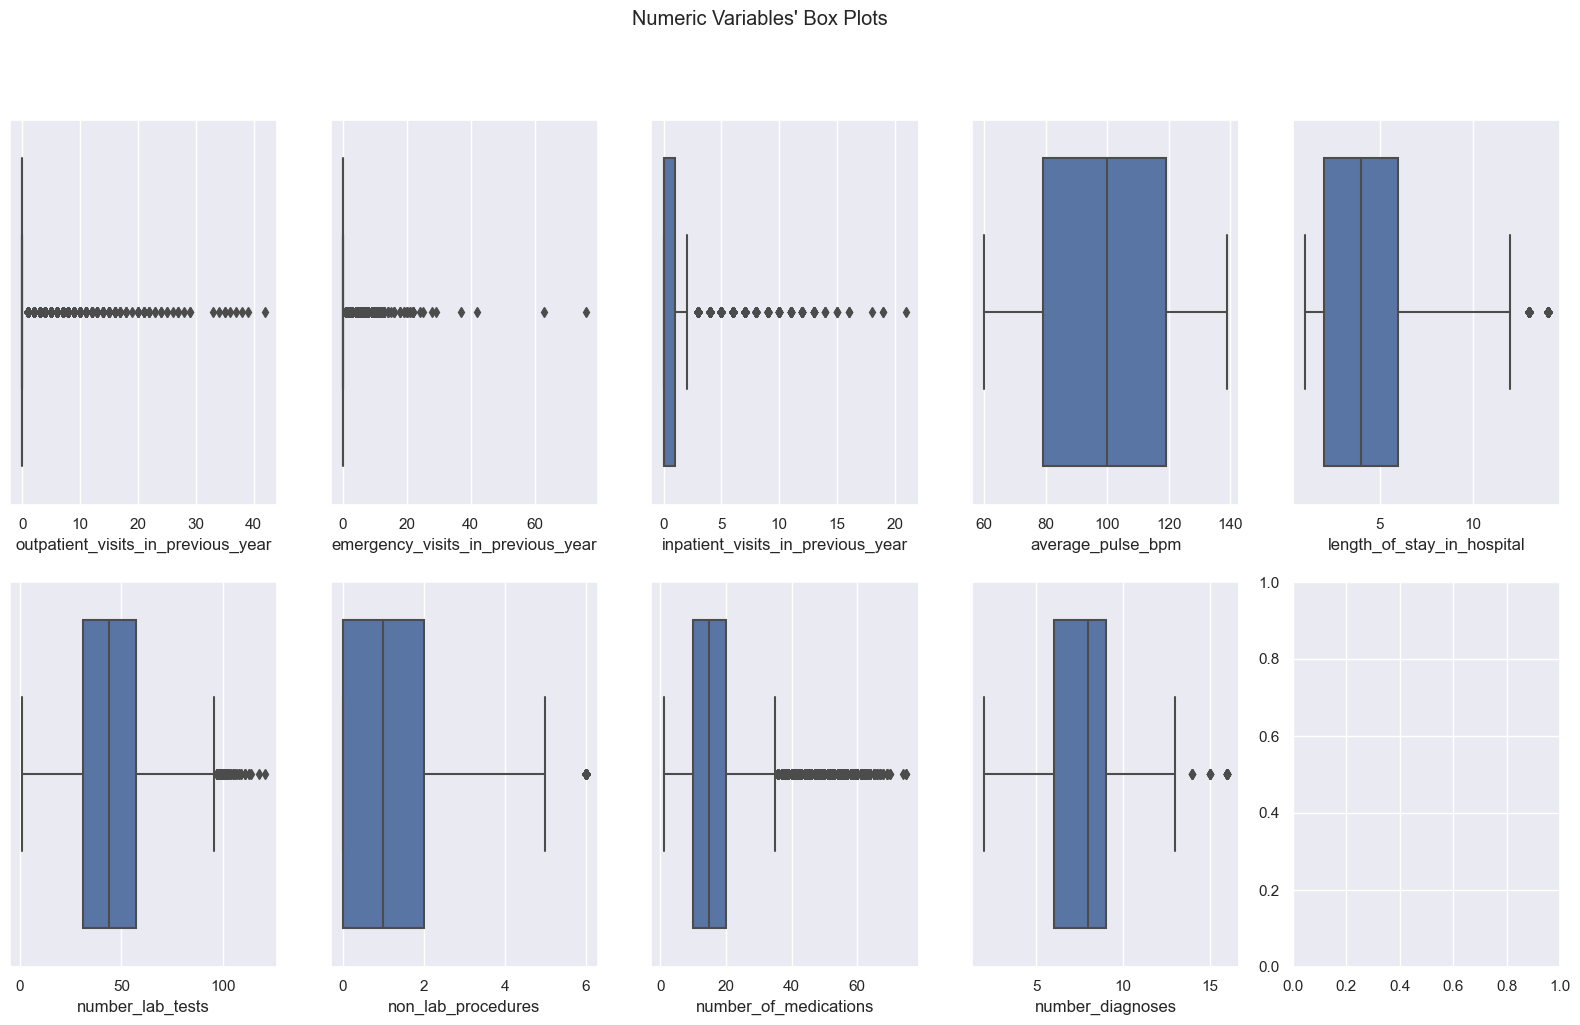

In [1615]:
from math import ceil
import os
import seaborn as sns

# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

# Save the figure
if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))
    
plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'numeric_variables_boxplots.png'), dpi=200)

plt.show()

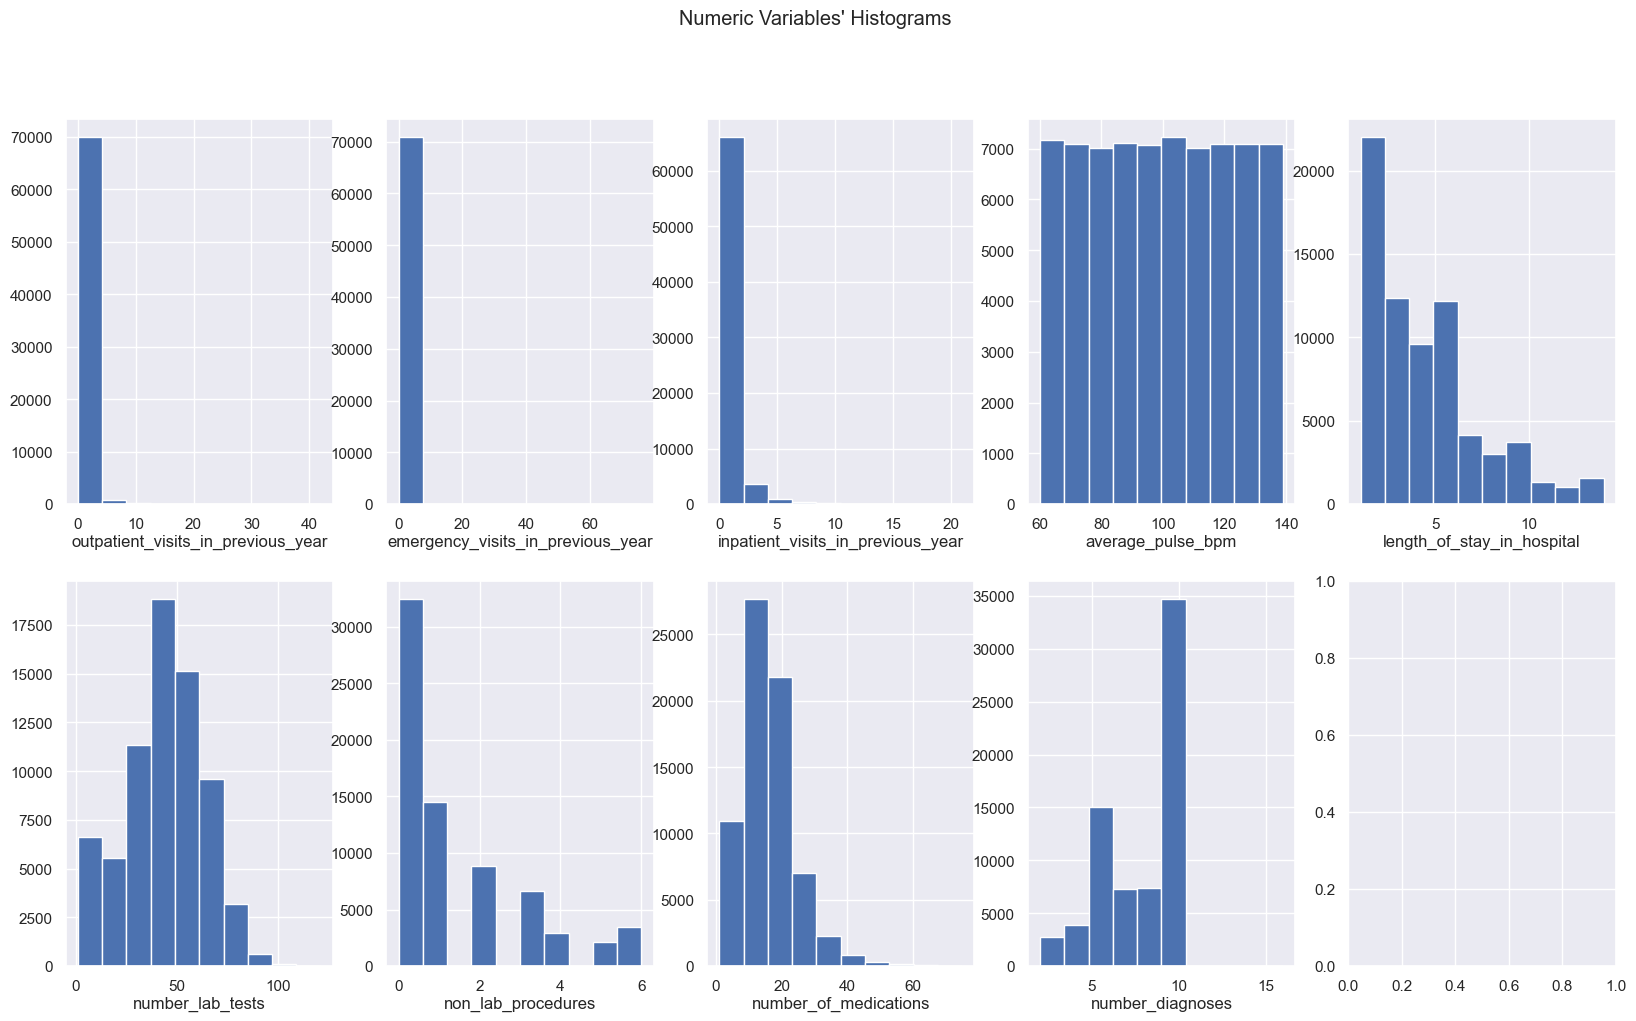

In [1616]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))
    
plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'numeric_variables_histograms.png'), dpi=200)

plt.show()

In [1617]:
#sns.set()

# Setting pairplot
#sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

#if not os.path.exists(os.path.join('..', 'figures', 'exp_analysis')):
    # if the exp_analysis directory is not present then create it first
    #os.makedirs(os.path.join('..', 'figures', 'exp_analysis'))
    
#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'pairwise_relationship_of_numerical_variables.png'), dpi=200)
#plt.show()

In [1618]:
#df['non_lab_procedures'].value_counts()

In [1619]:
df_1 = df.copy()

In [1620]:
# by analyzing the boxplots and the bar charts, there are some outliers that need to be removed

filters1 = (
    (df['outpatient_visits_in_previous_year']<=10)
    &
    (df['emergency_visits_in_previous_year']<=10)
    &
    (df['number_lab_tests']<=100)
    &
    (df['number_of_medications']<=50)
    &
    (df['number_diagnoses']<=10) # change to 13
)

df_1 = df[filters1]

In [1621]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4) * 100, '%')

Percentage of data kept after removing outliers: 99.1 %


## average_pulse_bpm

In [1675]:
df_1['average_pulse_bpm'].max()

139

## emergency_visits_in_previous_year

In [1677]:
df_1['emergency_visits_in_previous_year'].max()

10

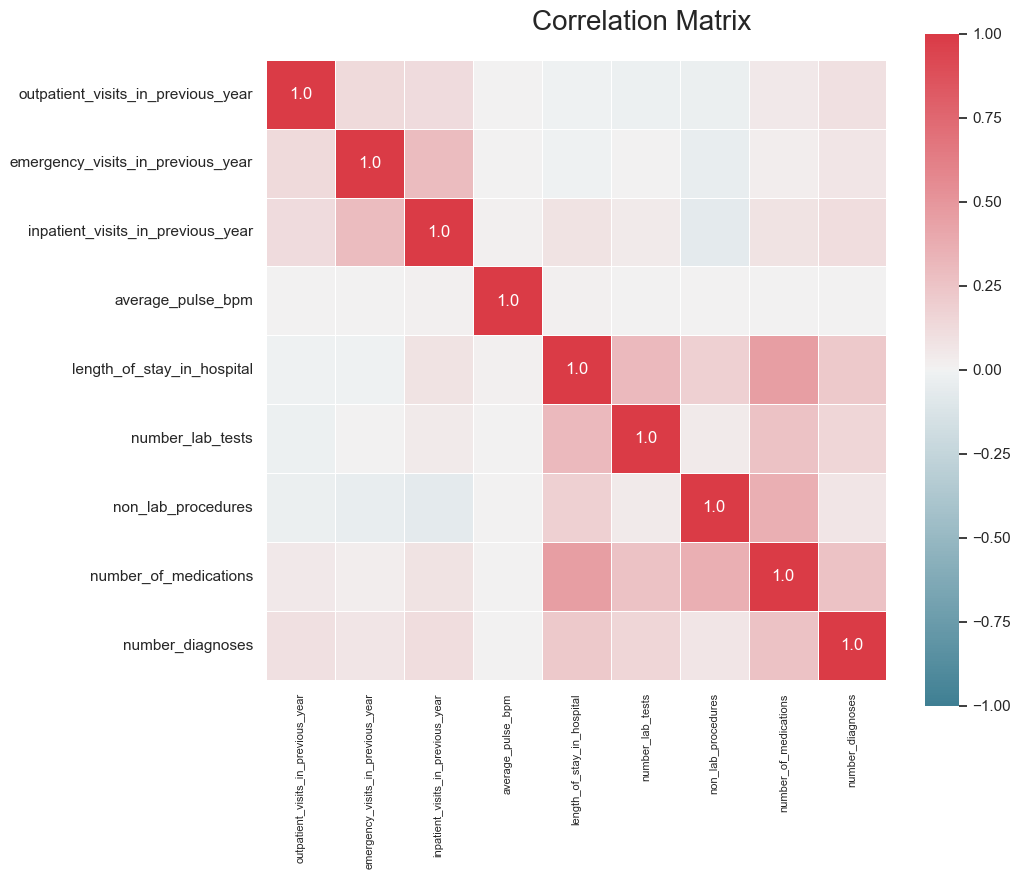

In [1681]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_1[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

# Explore non-numerical data
## Categorical/Low Cardinality Variables' Absolute Frequencies

In [1622]:
non_metric_features = df.columns.drop(metric_features + ['patient_id', 'readmitted_binary', 'readmitted_multiclass']).to_list()

In [1623]:
df_2 = df_1.copy()

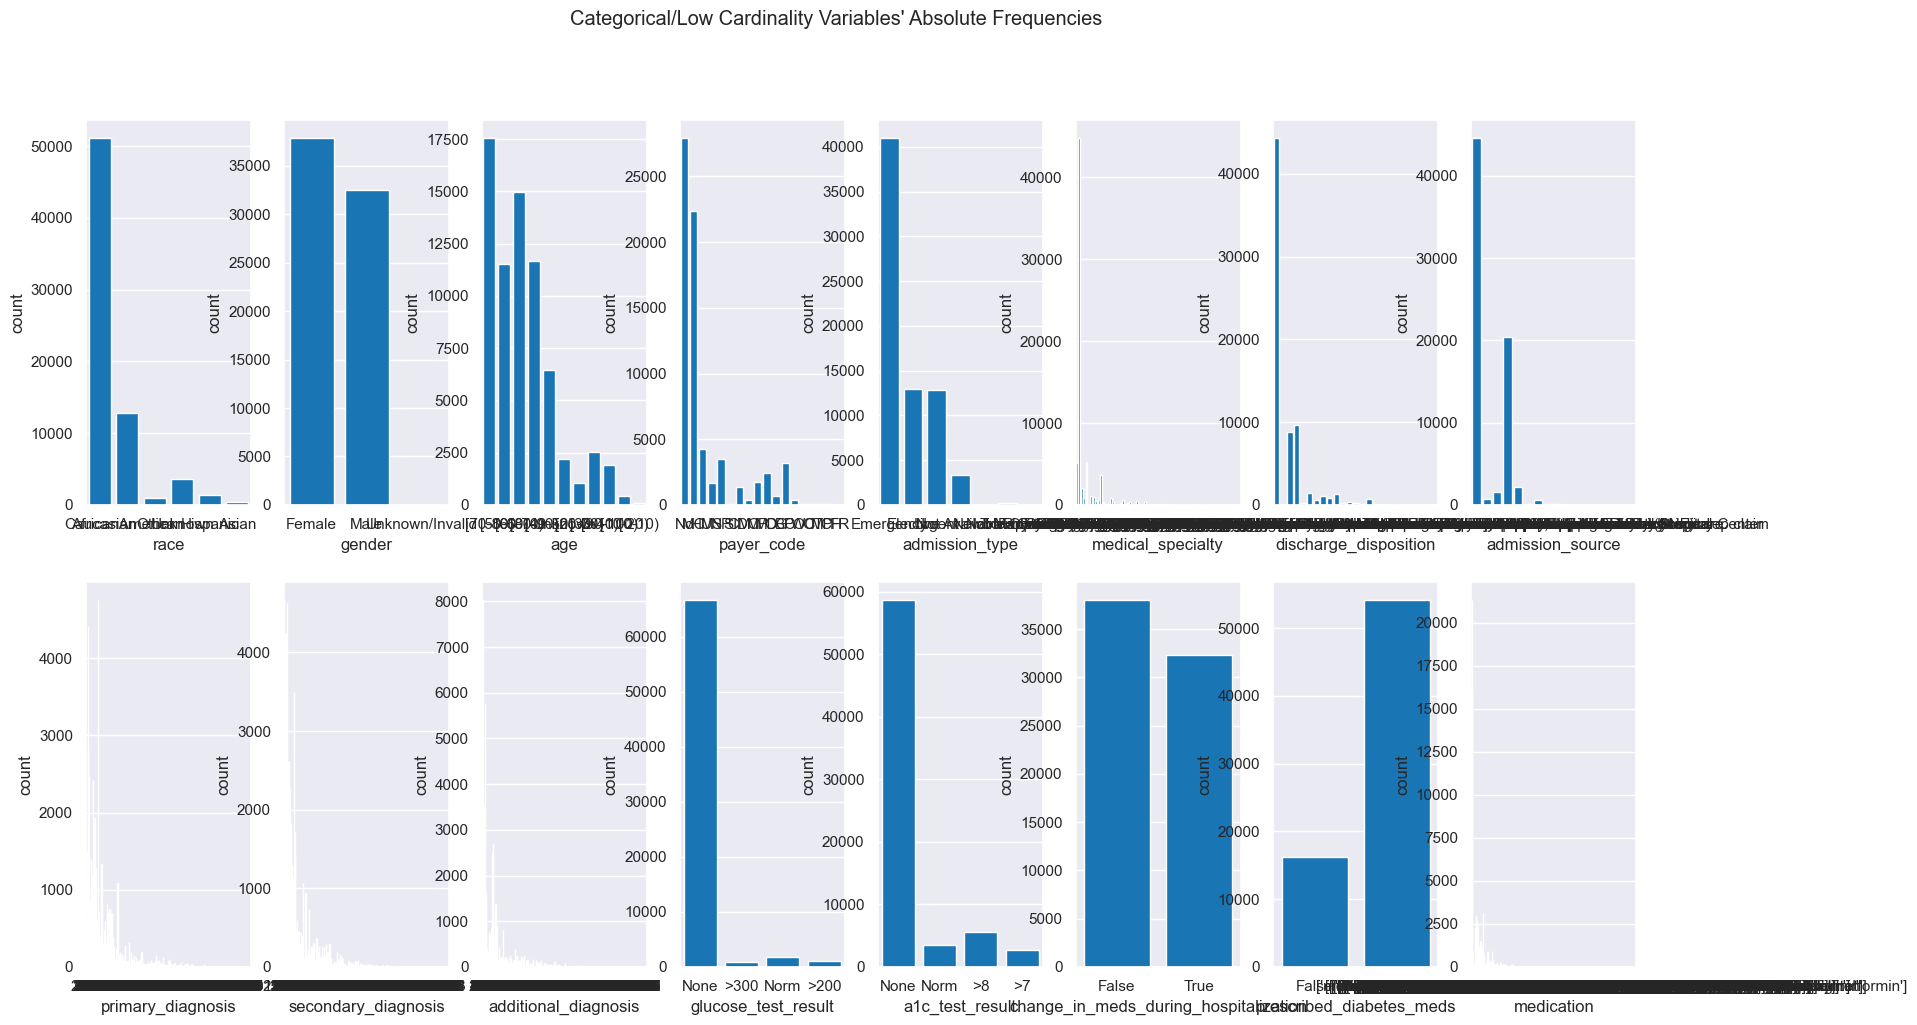

In [1624]:
# bad bar charts, impossible to read -> represent 1 by 1

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df_2[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

## race

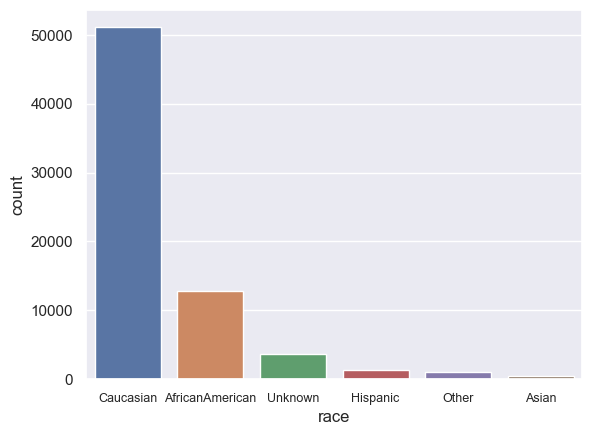

In [1625]:
sns.set() 
sns.set(rc={"xtick.labelsize": 9})  

race_order = df_2["race"].value_counts().index

sns.countplot(x=df_2["race"], order = race_order )
plt.show()

In [1626]:
df_2['race'].value_counts()

race
Caucasian          51086
AfricanAmerican    12843
Unknown             3593
Hispanic            1372
Other               1004
Asian                422
Name: count, dtype: int64

In [1627]:
# it might be a good approach to replace the "Unknown" label with "Other", because they are the same

df_2['race'] = df_2['race'].replace('Unknown', 'Other')

## age

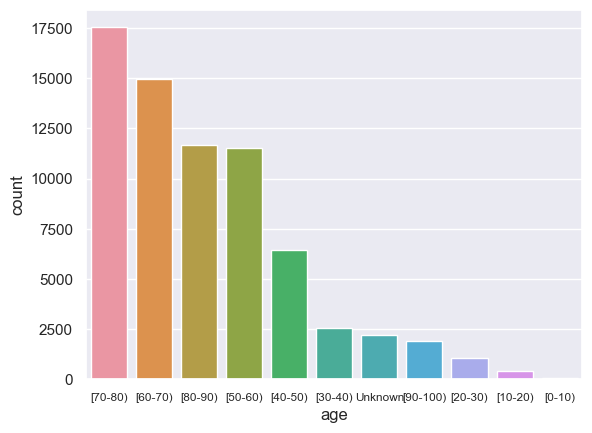

In [1628]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8.5})
# Sort the "age" column and create an ordered list
age_order = df_2["age"].value_counts().index

sns.countplot(x=df_2["age"], order=age_order)
plt.show()

In [1629]:
df_2['age'].value_counts()

age
[70-80)     17541
[60-70)     14957
[80-90)     11661
[50-60)     11536
[40-50)      6447
[30-40)      2531
Unknown      2192
[90-100)     1907
[20-30)      1062
[10-20)       411
[0-10)         75
Name: count, dtype: int64

## admission_type

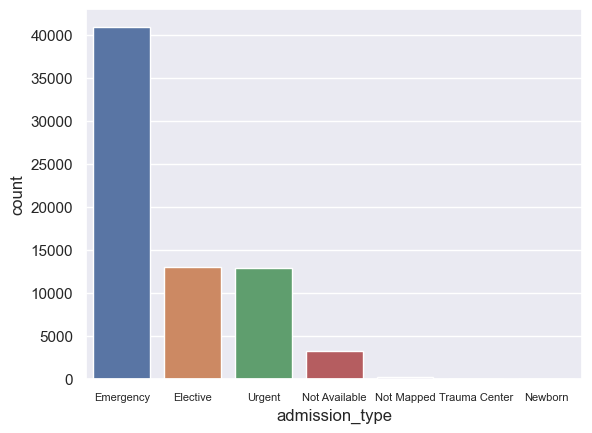

In [1630]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

admission_type_order = df_2["admission_type"].value_counts().index

sns.countplot(x=df_2["admission_type"], order = admission_type_order)
plt.show()

In [1631]:
df_2['admission_type'].value_counts()

admission_type
Emergency        40950
Elective         12981
Urgent           12859
Not Available     3299
Not Mapped         212
Trauma Center       13
Newborn              6
Name: count, dtype: int64

In [1632]:
# .taking into account the meaning of 'admission type', it is clear that neither 'newborn' nor 'trauma center' are an admission type 
# so, we drop them -> outliers
# also, 'not mapped' means the same as 'not avaliable, because it gives us no information, so it might be a good approach to merge them and rename to the label 'Unknown'

df_2 = df_2[~df_2['admission_type'].isin(['Newborn', 'Trauma Center'])]
df_2.loc[df_2['admission_type'].isin(['Not Available', 'Not Mapped']), 'admission_type'] = 'Unknown'

In [1633]:
df_2['admission_type'].value_counts()

admission_type
Emergency    40950
Elective     12981
Urgent       12859
Unknown       3511
Name: count, dtype: int64

## admission_source

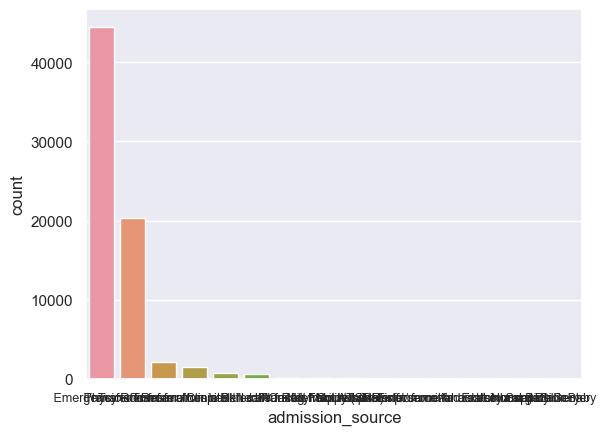

In [1634]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 9})  # Set the x-axis label size to 12

admission_source_order = df_2["admission_source"].value_counts().index

sns.countplot(x=df_2["admission_source"], order = admission_source_order)
plt.show()

In [1635]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

df_2['admission_source'].value_counts()

admission_source
 Emergency Room                                               44524
 Physician Referral                                           20368
Transfer from a hospital                                       2170
 Transfer from another health care facility                    1522
Clinic Referral                                                 773
 Transfer from a Skilled Nursing Facility (SNF)                 592
HMO Referral                                                    129
 Not Mapped                                                     106
 Not Available                                                   86
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                

-> It's the origin or place from which a patient was coming before being admitted to the current medical encounter or healthcare facility. In healthcare data, this information is recorded to track and categorize the various sources from which patients arrive at the hospital or healthcare setting, as it can be relevant for medical records, billing, and understanding patient demographics and medical history.

-> By analyzing the data above, it's clear that 'Sick Baby', 'Normal Delivery', 'Extramural Birth' are outliers -> drop them

-> "Court/Law Enforcement" category doesn't have relevance to out analysis or research, we considered removing it to simplify the dataset and focus on the aspects that are more pertinent to our objectives

-> Merge 'Phsysician Referral', 'Clinic Referral', 'HMO Referral', because it means the same: Patients referred by a healthcare provider or physician for further evaluation or treatment.

-> Merge 'Transfer from a hospital', 'Transfer from another health care facility', 'Transfer from a Skilled Nursing Facility (SNF)', 'Transfer from hospital inpt/same fac resulting in a separate claim', 'Transfer from critical access hospital', 'Transfer from Ambulatory Surgery Center', because the all mean that the patients were transferred.

-> Merge 'Not Mapped' and 'Not Available' to 'Unknwon', because both of them give the same information (no information) ---------> maybe delete them????

-> Delete Court/Law Enforcement ???


In [1636]:
df_2 = df_2[~df_2['admission_source'].isin([' Sick Baby', 'Normal Delivery', ' Extramural Birth', ' Court/Law Enforcement'])]

In [1637]:
df_2.loc[df_2['admission_source'].isin([' Physician Referral', 'Clinic Referral', 'HMO Referral']), 'admission_source'] = 'Referral'

In [1638]:
df_2.loc[df_2['admission_source'].isin(['Transfer from a hospital', ' Transfer from another health care facility', \
                                        ' Transfer from a Skilled Nursing Facility (SNF)', \
                                       ' Transfer from hospital inpt/same fac reslt in a sep claim', \
                                       ' Transfer from critial access hospital', \
                                       ' Transfer from Ambulatory Surgery Center']), 'admission_source'] = 'Transfer'

In [1639]:
df_2.loc[df_2['admission_source'].isin([' Not Mapped', ' Not Available']), 'admission_source'] = 'Unknown'

In [1640]:
df_2['admission_source'] = df_2['admission_source'].replace(' Emergency Room', 'Emergency Room')

In [1641]:
df_2['admission_source'].value_counts()

admission_source
Emergency Room    44524
Referral          21270
Transfer           4301
Unknown             192
Name: count, dtype: int64

## medical_specialty

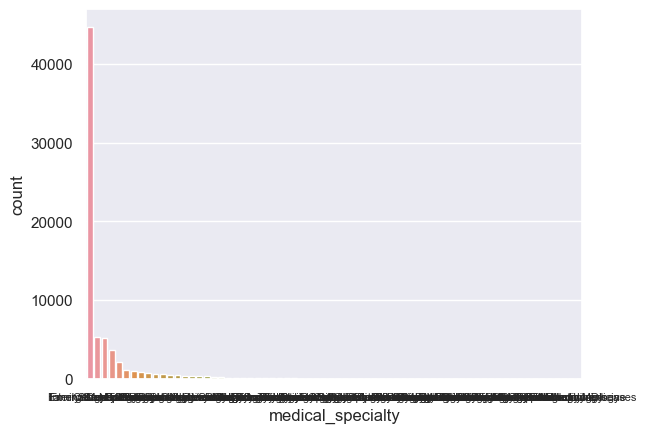

In [1642]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

medical_specialty_order = df_2["medical_specialty"].value_counts().index

sns.countplot(x=df_2["medical_specialty"], order = medical_specialty_order)
plt.show()

In [1643]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

df["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                 45093
Emergency/Trauma                  5303
Family/GeneralPractice            5190
Cardiology                        3713
Surgery-General                   2139
                                 ...  
Pediatrics-EmergencyMedicine         1
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Neurophysiology                      1
Name: count, Length: 68, dtype: int64

-> We start by analyzing the ones that are no medical specialties, having https://www.lusiadas.pt/en/hospitals-clinics/hospital-lusiadas-lisboa/specialties and https://www.hospitaldaluz.pt/lisboa/en/specialties?page=1&searchTerm= as a reference, so we drop them:

.Hospitalist
.Surgeon
.Osteopath -> Osteophathy
.Radiologist -> Radiology
.OutreachServices
.PhysicianNotFound 
.DCPTEAM
.Resident
.Speech


-> Inlude in other specialties:

.Endocrinology-Metabolism -> Endocrinology  <br>
.Orthopedics-Reconstructive -> Orthopedics <br>
.Oncology -> Hematology/Oncology  <br>
.Hematology -> Hematology/Oncology <br>
.Surgery-Thoracic -> Surgery-Cardiovascular/Thoracic  <br>
.Surgery-Cardiovascular -> Surgery-Cardiovascular/Thoracic  <br>
.Gynecology -> ObstetricsandGynecology <br>
.Obstetrics -> ObstetricsandGynecology <br>
.Obsterics&Gynecology-GynecologicOnco (a lot of specialties) -> ObstetricsandGynecology <br>
.Pediatrics-Pulmonology -> Pulmonology (OR Pediatrics) <br>
.Pediatrics-EmergencyMedicine -> Pediatrics (OR Emergency/Trauma) <br>
.Pediatrics-CriticalCare -> Pediatrics  <br>
.Pediatrics-Endocrinology -> Endocrinology (OR Pediatrics) <br>
.Anesthesiology-Pediatric -> Anesthesiology  <br>
.Pediatrics-AllergyandImmunology -> AllergyandImmunology (OR Pediatrics) <br>
.Pediatrics-InfectiousDiseases -> InfectiousDiseases (OR Pediatrics) <br>
.SurgicalSpecialty -> Surgery-General <br>
.Surgery-Colon&Rectal -> Proctology https://en.wikipedia.org/wiki/Colorectal_surgery <br>
.Pediatrics-Hematology-Oncology -> Hematology/Oncology (??) https://careersinmedicine.aamc.org/explore-options/specialty-profiles/pediatric-hematology-oncology <br>

---->Doubt:

.Surgery-Cardiovascular/Thoracic (arent these 2 specialties??) https://www.rcseng.ac.uk/news-and-events/media-centre/media-background-briefings-and-statistics/cardiothoracic-surgery/


-> Dont know what do to:

.Emergency/Trauma (??? left it)  -> it is already in admission_type...


-> Regarding Pediatrics-'something', we already know that is pediatrics due to its age, maybe we could add to the specialty 'something'

In [1644]:
values_to_drop = [
    'Hospitalist',
    'Surgeon',
    'Osteopath',
    'Radiologist',
    'OutreachServices', 
    'PhysicianNotFound',
    'DCPTEAM',
    'Resident',
    'Speech'
]

df_2 = df_2[~df_2['medical_specialty'].isin(values_to_drop)]

In [1645]:
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Orthopedics-Reconstructive', 'Orthopedics')
df_2.loc[df_2['medical_specialty'].isin(['Oncology', 'Hematology']), 'medical_specialty'] = 'Hematology/Oncology'
df_2.loc[df_2['medical_specialty'].isin(['Surgery-Thoracic', 'Surgery-Cardiovascular']), 'medical_specialty'] = 'Surgery-Cardiovascular/Thoracic'
df_2.loc[df_2['medical_specialty'].isin(['Gynecology', 'Obstetrics', 'Obsterics&Gynecology-GynecologicOnco']), 'medical_specialty'] = 'ObstetricsandGynecology'
df_2.loc[df_2['medical_specialty'].isin(['Pediatrics-EmergencyMedicine', 'Pediatrics-CriticalCare']), 'medical_specialty'] = 'Pediatrics'
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Pediatrics-Pulmonology', 'Pulmonology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Pediatrics-Endocrinology', 'Endocrinology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Anesthesiology-Pediatric', 'Anesthesiology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Pediatrics-AllergyandImmunology', 'AllergyandImmunology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Pediatrics-InfectiousDiseases', 'InfectiousDiseases')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('SurgicalSpecialty', 'Surgery-General')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Surgery-Colon&Rectal', 'Proctology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Pediatrics-Hematology-Oncology', 'Hematology/Oncology')
df_2['medical_specialty'] = df_2['medical_specialty'].replace('Endocrinology-Metabolism', 'Endocrinology')

In [1646]:
df_2["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                     44706
Emergency/Trauma                      5266
Family/GeneralPractice                5165
Cardiology                            3657
Surgery-General                       2150
Orthopedics                           1807
Nephrology                            1129
Pulmonology                            621
Psychiatry                             594
ObstetricsandGynecology                546
Surgery-Cardiovascular/Thoracic        500
Urology                                471
Hematology/Oncology                    452
Gastroenterology                       396
Surgery-Vascular                       363
Surgery-Neuro                          317
PhysicalMedicineandRehabilitation      280
Pediatrics                             216
Endocrinology                          160
Neurology                              137
Otolaryngology                          86
Podiatry                                72
Psychology                          

## discharge_disposition

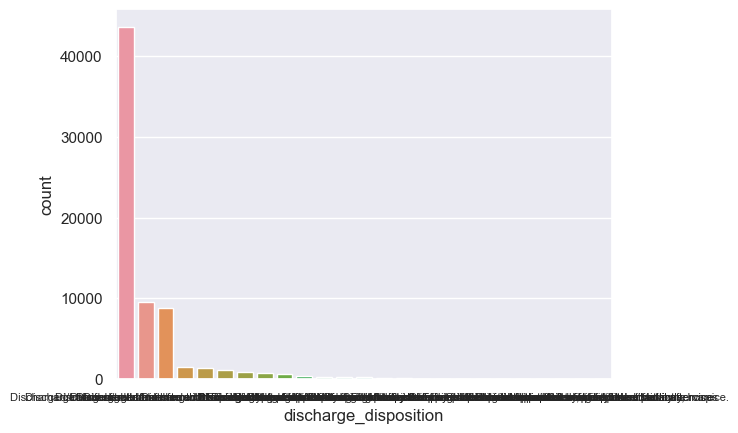

In [1647]:
sns.set() # Reset the formatting defaults
sns.set(rc={"xtick.labelsize": 8})  # Set the x-axis label size to 12

medical_specialty_order = df_2["discharge_disposition"].value_counts().index

sns.countplot(x=df_2["discharge_disposition"], order = medical_specialty_order)
plt.show()

In [1648]:
## difficult to get insights from the graphic above because there are a lot of values, so we try this

df_2["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           43640
Discharged/transferred to SNF                                                                                 9587
Discharged/transferred to home with home health service                                                       8744
Discharged/transferred to another short term hospital                                                         1451
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1322
Expired                                                                                                       1100
Discharged/transferred to another type of inpatient care institution                                           812
Not Mapped                                                                                                     673
Discharged/transferred to ICF                             

Group some categories in the "discharge_disposition" column if they have similar meanings

.Home:

    "Discharged to home"
    "Discharged/transferred to home with home health service"
    "Discharged/transferred to home under care of Home IV provider"
 
.Rehab/Medical Facility:

    "Discharged/transferred to SNF" (Skilled Nurse Facility)
    "Discharged/transferred to another short term hospital"
    "Discharged/transferred to another rehab fac including rehab units of a hospital"
    "Discharged/transferred to ICF" (Intermediate Care Facility)
    "Discharged/transferred to a long term care hospital."
    
.Hospice:

    "Hospice / medical facility"
    "Hospice / home"
    
.Expired:

    "Expired" (Patient who has passed away)
    "Expired at home. Medicaid only, hospice."
    "Expired in a medical facility. Medicaid only, hospice."
    
.Psychiatric:

    "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital"
    
.Inpatient:

    "Discharged/transferred to another type of inpatient care institution"
    "Admitted as an inpatient to this hospital"
    
.Other:

    "Left AMA"
    "Discharged/transferred/referred to this institution for outpatient services"
    "Discharged/transferred/referred another institution for outpatient services"
    "Discharged/transferred to a federal health care facility."
    "Neonate discharged to another hospital for neonatal aftercare"
    "Still patient or expected to return for outpatient services"


<b>BEST APPROACH:<b> <br>
2 groups: 'home' & 'not home'; it's not important to know were they were discharged if it was not home

In [1649]:
#df_2.loc[df_2['discharge_disposition'].isin(['Discharged to home', 'Discharged/transferred to home with home health service', 'Discharged/transferred to home under care of Home IV provider']), 'discharge_disposition'] = 'Home'
#df_2.loc[df_2['discharge_disposition'].isin(['Discharged/transferred to SNF" (Skilled Nurse Facility)', 'Discharged/transferred to another short term hospital', 'Discharged/transferred to another rehab fac including rehab units of a hospital','Discharged/transferred to ICF" (Intermediate Care Facility)', 'Discharged/transferred to a long term care hospital.']), 'discharge_disposition'] = 'Rehab'
#df_2.loc[df_2['discharge_disposition'].isin(['Hospice / medical facility', 'Hospice / home']), 'discharge_disposition'] = 'Hospice'
#df_2.loc[df_2['discharge_disposition'].isin(['Expired" (Patient who has passed away)', 'Expired at home. Medicaid only, hospice.', 'Expired in a medical facility. Medicaid only, hospice.']), 'discharge_disposition'] = 'Expired'
#df_2.loc[df_2['discharge_disposition'].isin(['Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital']), 'discharge_disposition'] = 'Psychiatric'
#df_2.loc[df_2['discharge_disposition'].isin(['Discharged/transferred to another type of inpatient care institution', 'Admitted as an inpatient to this hospital']), 'discharge_disposition'] = 'Inpatient'
#df_2.loc[df_2['discharge_disposition'].isin(['Left AMA', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services',\
                                            #'Discharged/transferred to a federal health care facility.',\
                                            #'Neonate discharged to another hospital for neonatal aftercare',\
                                            #'Still patient or expected to return for outpatient services']), 'discharge_disposition'] = 'Other'

In [1650]:
# home:1
# not home: 0

df_2['discharge_disposition'].replace({'Discharged to home': 1, 'Discharged/transferred to home with home health service': 1, 'Discharged/transferred to home under care of Home IV provider': 1, 'Expired at home. Medicaid only, hospice.': 1, 'Hospice / home': 1}, inplace=True)
df_2['discharge_disposition'].replace(to_replace='.*', value=0, regex=True, inplace=True)


In [1651]:

# Change the name of the 'discharge_disposition' to 'discharged_home'
df_2.rename(columns={'discharge_disposition': 'discharged_home'}, inplace=True)

# Change the data type of the 'column_name' to boolean (bool)
df_2['discharged_home'] = df_2['discharged_home'].astype(bool)

df_2['discharged_home'].value_counts()

discharged_home
True     52723
False    16647
Name: count, dtype: int64

## analyse 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis

group codes according to wikipedia
https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [1652]:
# group 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis' into icd9 groups

icd9_mapping = {
    (1, 139): 1,      # List of ICD-9 codes 001–139: infectious and parasitic diseases
    (140, 239): 2,    # List of ICD-9 codes 140–239: neoplasms
    (240, 279): 3,    # List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
    (280, 289): 4,    # List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
    (290, 319): 5,    # List of ICD-9 codes 290–319: mental disorders
    (320, 389): 6,    # List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
    (390, 459): 7,    # List of ICD-9 codes 390–459: diseases of the circulatory system
    (460, 519): 8,    # List of ICD-9 codes 460–519: diseases of the respiratory system
    (520, 579): 9,    # List of ICD-9 codes 520–579: diseases of the digestive system
    (580, 629): 10,   # List of ICD-9 codes 580–629: diseases of the genitourinary system
    (630, 679): 11,   # List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
    (680, 709): 12,   # List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
    (710, 739): 13,   # List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
    (740, 759): 14,   # List of ICD-9 codes 740–759: congenital anomalies
    (760, 779): 15,   # List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
    (780, 799): 16,   # List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
    (800, 999): 17,   # List of ICD-9 codes 800–999: injury and poisoning
    ('E', 'E999'): 18,  # External causes of injury and supplemental classification starting with 'E'
    ('V', 'V91'): 18,   # External causes of injury and supplemental classification starting with 'V'
}

def map_icd9_to_category(icd9_code):
    for code_range, category in icd9_mapping.items():
        if isinstance(code_range, tuple):
            # Numeric range
            start, end = code_range
            try:
                if start <= int(icd9_code) <= end:
                    return category
            except ValueError:
                continue  # Skip invalid numeric codes
        elif code_range[0] == 'E' or code_range[0] == 'V':
            # String range for E and V codes
            if code_range[0] <= icd9_code <= code_range[1]:
                return category
    #return None


df_2['primary_diagnosis'] = df_2['primary_diagnosis'].apply(map_icd9_to_category)
df_2['secondary_diagnosis'] = df_2['secondary_diagnosis'].apply(map_icd9_to_category)
df_2['additional_diagnosis'] = df_2['additional_diagnosis'].apply(map_icd9_to_category)

In [1653]:
#df_2['primary_diagnosis'].value_counts()

In [1654]:
#df_2['secondary_diagnosis'].value_counts()

In [1655]:
#df_2['additional_diagnosis'].value_counts()

In [1656]:
# the most repeated combination of 'primary_diagnosis', 'secondary_diagnosis' and 'additional_diagnosis'

grouped = df_2.groupby(['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']).size().reset_index(name='count')
max = grouped['count'].max()
grouped[grouped['count'] == max]

#414: Other forms of chronic ischemic heart disease
#411: Other acute and subacute forms of ischemic heart disease
#250: Diabetes mellitus

,primary_diagnosis,secondary_diagnosis,additional_diagnosis,count
957,7.0,7.0,7.0,4447


# Feature Engineering

## payer_code
rename to has_insurance: True or False; because it is more important to know if people have insurance instead the name of the insurance

In [1657]:
df['has_insurance'] = df['payer_code'] != 'No'
df['has_insurance'] = df['has_insurance'].astype(bool)
df.drop('payer_code', axis=1, inplace=True)

In [1658]:
# Get the 'has_insurance' column
has_insurance = df.pop('has_insurance')

# Insert it the 5th column of the DataFrame
df.insert(4, 'has_insurance', has_insurance)

## medication

-> Create 3 new columns, for the first 3 most used medications <br>
-> Create a new column tha stores the number of medications

In [1659]:
#df_2['medication'].value_counts()

In [1660]:
## create a Df that stores how many times each medication is in the column

# clean up the medication column
medication = df_2['medication'].str.replace(r"[',\[\]]", "", regex=True).str.split()

# flatten the list of medications and count occurrences
medication_counts = Counter([med for sublist in medication for med in sublist])

# create a DataFrame to display the counts
medication_df = pd.DataFrame({'Medication': medication_counts.keys(), 'Count': medication_counts.values()})

#medication_df


In [1661]:
## create a column that stores the number of medications per row

# Calculate the frequency of each medication
medication_counts = df_2['medication'].value_counts()
total_columns = df_2.shape[1]


# Create binary columns for selected medications and total medication count

# Create a column for the total number of medications prescribed
col = df_2['medication'].apply(lambda x: len(eval(x)))
insert_index = total_columns - 4
df_2.insert(insert_index, 'num_medication', col)


## create 3 new boolean columns for the 3 most used medications

# Select the top 3 most commonly prescribed medications
top_medications = medication_df['Medication'].head(3)


# Calculate the index to insert new columns at the 3 last positions
insert_index1 = total_columns - 3

# Insert the binary columns for selected medications at the 3 last positions of the DataFrame
for medication in top_medications:
    # Create a binary column for each selected medication
    df_2.insert(insert_index1, f'{medication}_prescribed', df_2['medication'].apply(lambda x: medication in x))


In [1662]:
#df_2.head(5)

In [1663]:
# drop 'medication' column
df_2.drop('medication', axis=1, inplace=True)

In [1668]:
pd.set_option('display.max_columns', None)
df_2.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharged_home,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,num_medication,metformin_prescribed,glimepiride_prescribed,insulin_prescribed,prescribed_diabetes_meds,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
533192,70110,Caucasian,Female,[70-80),No,0,0,2,Emergency,Family/GeneralPractice,86,True,Emergency Room,2,48,0,20,8.0,3.0,8.0,8,None,None,False,0,False,False,False,False,False,2
426845,29775006,AfricanAmerican,Male,[50-60),No,0,0,0,Emergency,InternalMedicine,82,False,Referral,14,71,0,25,1.0,16.0,2.0,9,None,None,False,1,False,False,True,True,False,0
110358,80729253,Caucasian,Female,[60-70),No,0,0,1,Emergency,Family/GeneralPractice,88,True,Emergency Room,6,60,1,22,9.0,1.0,3.0,6,None,None,True,2,False,True,True,True,False,0
628963,2919042,AfricanAmerican,Male,[60-70),MC,0,0,1,Emergency,InternalMedicine,129,True,Transfer,6,48,2,9,9.0,9.0,7.0,5,None,None,False,0,False,False,False,False,False,0
130580,84871971,Caucasian,Female,[70-80),HM,1,0,0,Elective,InternalMedicine,121,True,Referral,6,47,1,15,13.0,10.0,7.0,9,None,None,False,0,False,False,False,False,False,2
